# Abalone Rings Classification using LSTM

LSTM is an architecture that can leverage sequence data with temporal information. However, samples in abalone dataset is sampled independently, and has no temporal relations between features. In other words, the order of the id is not related to rings and the order of columns is not related to rings. RNN-like model is not suitable to abalone dataset.

Nevertheless, there might be hidden something in the dataset. In my experiments, adapting LSTM to abalone dataset has two directions.

1. Considering each data sample as a item in a sequence sequence.
2. Considering each feature in a data sample as a item in a sequence.

## Method 1: Considering each data sample as a item in a sequence

In [1]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader

In [2]:
seed = 42

np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ["PYTHONHASHSEED"] = str(seed)

In [3]:
data = pd.read_csv('data/abalone.csv')
data['Sex'] = data['Sex'].map({'M': 0, 'F': 1, 'I': 2})

X = data.drop(['Rings', 'id'], axis=1).values
y = data['Rings'].values - 1

In [4]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.LongTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val_scaled)
y_val_tensor = torch.LongTensor(y_val)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.LongTensor(y_test)

In [5]:
class AbaloneSequenceDataset(Dataset):
    def __init__(self, X, y, sequence_length=5):
        self.X = X
        self.y = y
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.X) - self.sequence_length + 1

    def __getitem__(self, idx):
        return (self.X[idx:idx+self.sequence_length], self.y[idx+self.sequence_length-1])

In [6]:
train_dataset = AbaloneSequenceDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = AbaloneSequenceDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataset = AbaloneSequenceDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [7]:
class AbaloneLSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(AbaloneLSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

hidden_size = 64
num_layers = 2
num_classes = len(np.unique(y)) + 1
net = AbaloneLSTMClassifier(X.shape[1], hidden_size, num_layers, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [9]:
num_epochs = 100
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    net.train()

    train_correct = 0
    train_total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    
    train_accuracy = train_correct / train_total
    train_accuracies.append(train_accuracy)

    net.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = val_correct / val_total
    val_accuracies.append(val_accuracy)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Epoch [10/100], Train Accuracy: 0.2468, Validation Accuracy: 0.2375
Epoch [20/100], Train Accuracy: 0.2725, Validation Accuracy: 0.2392
Epoch [30/100], Train Accuracy: 0.2866, Validation Accuracy: 0.2547
Epoch [40/100], Train Accuracy: 0.3119, Validation Accuracy: 0.2754
Epoch [50/100], Train Accuracy: 0.3385, Validation Accuracy: 0.2754
Epoch [60/100], Train Accuracy: 0.3766, Validation Accuracy: 0.2719
Epoch [70/100], Train Accuracy: 0.4177, Validation Accuracy: 0.2633
Epoch [80/100], Train Accuracy: 0.4841, Validation Accuracy: 0.2444
Epoch [90/100], Train Accuracy: 0.5463, Validation Accuracy: 0.2530
Epoch [100/100], Train Accuracy: 0.6285, Validation Accuracy: 0.2427


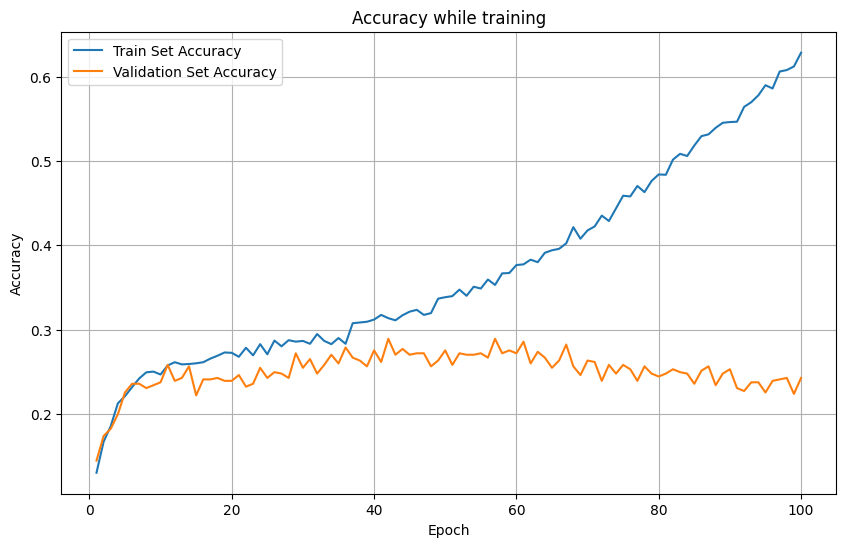

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Set Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Set Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy while training')
plt.legend()
plt.grid(True)
plt.show()
plt.close()

In [11]:
net.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.2264


## Method 2: Considering each feature in a data sample as a item in a sequence

In [1]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader

In [2]:
seed = 42

np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ["PYTHONHASHSEED"] = str(seed)

In [3]:
data = pd.read_csv('data/abalone.csv')
data['Sex'] = data['Sex'].map({'M': 0, 'F': 1, 'I': 2})

X = data.drop(['Rings', 'id'], axis=1).values
y = data['Rings'].values - 1

In [4]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.LongTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val_scaled)
y_val_tensor = torch.LongTensor(y_val)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.LongTensor(y_test)

In [5]:
class AbaloneSequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [6]:
train_dataset = AbaloneSequenceDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = AbaloneSequenceDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataset = AbaloneSequenceDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [7]:
class AbaloneLSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(AbaloneLSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

hidden_size = 64
num_layers = 2
num_classes = len(np.unique(y)) + 1
net = AbaloneLSTMClassifier(8, hidden_size, num_layers, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [9]:
num_epochs = 100
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    net.train()

    train_correct = 0
    train_total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs.unsqueeze(1))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    
    train_accuracy = train_correct / train_total
    train_accuracies.append(train_accuracy)

    net.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs.unsqueeze(1))
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = val_correct / val_total
    val_accuracies.append(val_accuracy)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Epoch [10/100], Train Accuracy: 0.2541, Validation Accuracy: 0.2462
Epoch [20/100], Train Accuracy: 0.2750, Validation Accuracy: 0.2701
Epoch [30/100], Train Accuracy: 0.2750, Validation Accuracy: 0.2769
Epoch [40/100], Train Accuracy: 0.2836, Validation Accuracy: 0.2838
Epoch [50/100], Train Accuracy: 0.2776, Validation Accuracy: 0.2786
Epoch [60/100], Train Accuracy: 0.2917, Validation Accuracy: 0.2735
Epoch [70/100], Train Accuracy: 0.2849, Validation Accuracy: 0.2872
Epoch [80/100], Train Accuracy: 0.2930, Validation Accuracy: 0.2821
Epoch [90/100], Train Accuracy: 0.2943, Validation Accuracy: 0.2769
Epoch [100/100], Train Accuracy: 0.3011, Validation Accuracy: 0.2701


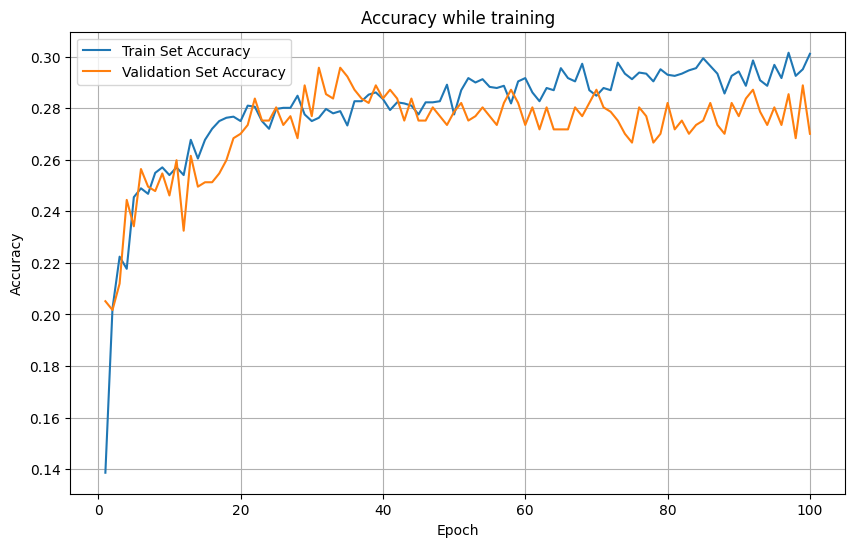

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Set Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Set Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy while training')
plt.legend()
plt.grid(True)
plt.show()
plt.close()

In [11]:
net.eval()
with torch.no_grad():
    test_outputs = net(X_test_tensor.unsqueeze(1).to(device))
    _, predicted = torch.max(test_outputs.data, 1)
    accuracy = accuracy_score(y_test, predicted)
    print(f"Test Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, predicted))

Test Accuracy: 0.2879
Classification Report:
              precision    recall  f1-score   support

           2       0.00      0.00      0.00         3
           3       0.38      0.68      0.49        19
           4       0.38      0.13      0.20        45
           5       0.36      0.44      0.40        77
           6       0.42      0.38      0.40       129
           7       0.39      0.30      0.34       164
           8       0.32      0.36      0.34       212
           9       0.23      0.43      0.30       191
          10       0.29      0.26      0.27       137
          11       0.67      0.02      0.05        84
          12       0.10      0.19      0.13        53
          13       0.00      0.00      0.00        34
          14       0.10      0.03      0.05        31
          15       0.14      0.14      0.14        21
          16       0.00      0.00      0.00        14
          17       0.00      0.00      0.00        15
          18       0.00      0.00   

/Users/measaverb/miniconda3/envs/ai-class/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/measaverb/miniconda3/envs/ai-class/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/measaverb/miniconda3/envs/ai-class/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier